In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['svg.fonttype']='none'

In [3]:
###GZMK12
def get_pairs(order,treatment):
    box_pairs=[]
    for group in order:
        box_pairs.append([(group,x) for x in treatment])
    return box_pairs

def get_statistics(path,col):
    count_data=pd.read_csv(path,index_col=0)
    count_data['Group']=count_data['sample'].str.endswith('surgery')*1
    count_data_dict=count_data.groupby('sample').sum()['count'].to_dict()
    count_data['percentage']=count_data.apply(lambda x:x['count']/count_data_dict[x[0]],axis=1)
    count_data['group class']=count_data.apply(lambda x:'Biopsy' if x['Group']==0 else 'Surgery',axis=1)
    cell_type_order=list(count_data[col].value_counts().index)
    treatment=['Biopsy','Surgery']
    box_pairs=get_pairs(cell_type_order,treatment)
    return count_data,box_pairs,cell_type_order

def get_ratio_df(T_cell_subtypes,colnames):
    T_cell_subtypes_pre=[]
    T_cell_subtypes_post=[]
    for index,value in T_cell_subtypes.groupby(colnames):
        key=','.join(index)
        if 'biopsy' in key:
            T_cell_subtypes_pre.append(key)
        elif 'surgery' in key:
            T_cell_subtypes_post.append(key)

    patient_T_Cell_type={}
    for index,value in T_cell_subtypes.groupby(colnames):
        key=','.join(index)
        patient_T_Cell_type[key]=value['percentage'].sum()

    T_cell_type_ratio={}
    tumor_change_IM={}
    for key1,key2 in zip(T_cell_subtypes_pre,T_cell_subtypes_post):
        pateint_val=key2.split(',')[0]
        T_cell_type_ratio[key2]=patient_T_Cell_type[key2]/patient_T_Cell_type[key1]
        tumor_change_IM[key2]=tumor_change[pateint_val]

    T_cell_type_ratio_df=pd.DataFrame.from_dict(T_cell_type_ratio,orient='index')
    T_cell_type_ratio_df.columns=['ratio']
    tumor_changeIM_df=pd.DataFrame.from_dict(tumor_change_IM,orient='index')
    tumor_changeIM_df.columns=['tumor change']


    T_cell_type_ratio_df['tumor change'] = tumor_changeIM_df[['tumor change']]

    T_cell_type_ratio_df['cell_types']=T_cell_type_ratio_df.index.str.split(',')

    T_cell_type_ratio_df['cell_type']=T_cell_type_ratio_df.apply(lambda x:x['cell_types'][1],axis=1)

    T_cell_type_ratio_df['log ratio'] =np.log10(T_cell_type_ratio_df['ratio'])
    return T_cell_type_ratio_df

In [1]:
#tumor_change={'guozhixing_surgery':-45.57,'zhuanglili_surgery':-31.26,'sunzhengyun_surgery':-42.0,'nianshizhu_surgery':-20.52,'lilanying_surgery':-14.84,'wangzhu_surgery':-65.63,'zhouyunmei_surgery':-20.45,'wandeyuan_surgery':-31.7}

In [5]:
###GZMB/proliferationg
T_cell_subtypes,box_pairs,cell_type_order_subtypes=get_statistics("statistics/T_further_subtypes_counts.csv",'T_cell_further_subtype')

In [6]:
tumor_change2={}
for key,value in tumor_change.items():
    tumor_change2[key]=value
    tumor_change2[key.split("_")[0]+'_'+'biopsy']=value



In [7]:
result_GK_GB={}
result_GB_pro={}
result_GK_pro={}
for key,value in T_cell_subtypes.groupby(['sample']):
    GB=list(value.loc[value['T_cell_further_subtype']=='CD8 GZMB','percentage'])[0]
    GK=sum(value.loc[value['T_cell_further_subtype'].str.startswith('CD8 GZMK'),'percentage'])
    pro=list(value.loc[value['T_cell_further_subtype']=='CD8 proliferating','percentage'])[0]
    result_GK_GB[key]=GK/GB
    result_GB_pro[key]=GB/pro
    result_GK_pro[key]=GK/pro

In [8]:
def get_df(result,col_name):
    result_df=pd.DataFrame.from_dict(result,orient="index")
    result_df.columns=[col_name]
    result_df['sample']=result_df.index

    result_df2=result_df.drop(['caiwanqiang','shiyi']).copy()
    result_df2['change']=result_df2.apply(lambda x:tumor_change2[x['sample']],axis=1)
    result_df2['group']=result_df2['sample'].str.endswith('surgery')*1
    return result_df2

In [9]:
GZMK_GZMB=get_df(result_GK_GB,'GK_GB')
GZMK_pro=get_df(result_GK_pro,'GK_pro')
GZMB_pro=get_df(result_GB_pro,'GB_pro')

In [10]:
GZMK_GZMB_biopsy=GZMK_GZMB.loc[GZMK_GZMB['group']==0].copy()
GZMK_pro_biopsy=GZMK_pro.loc[GZMK_pro['group']==0].copy()
GZMB_pro_biopsy=GZMB_pro.loc[GZMB_pro['group']==0].copy()

In [11]:
##change
GZMK_GZMB_surgey=GZMK_GZMB.loc[GZMK_GZMB['group']==1].copy()
GZMK_pro_surgery=GZMK_pro.loc[GZMK_pro['group']==1].copy()
GZMB_pro_surgery=GZMB_pro.loc[GZMB_pro['group']==1].copy()

In [14]:
GZMK_GZMB_surgey['ratio']=GZMK_GZMB_surgey['GK_GB'].values/GZMK_GZMB_biopsy['GK_GB'].values
GZMK_pro_surgery['ratio']=GZMK_pro_surgery['GK_pro'].values/GZMK_pro_biopsy['GK_pro'].values
GZMB_pro_surgery['ratio']=GZMB_pro_surgery['GB_pro'].values/GZMB_pro_biopsy['GB_pro'].values

In [15]:
import numpy as np

In [16]:
GZMK_GZMB_biopsy['logratio']=np.log(GZMK_GZMB_biopsy['GK_GB'])
GZMK_pro_biopsy['logratio']=np.log(GZMK_pro_biopsy['GK_pro'])
GZMB_pro_biopsy['logratio']=np.log(GZMB_pro_biopsy['GB_pro'])

In [41]:
#GZMK_GZMB_surgey['GK_GB']/GZMK_GZMB_biopsy['GK_GB']

In [17]:
import scipy.stats as sst

In [44]:
GKBpor_tipi=open("GKBpor_tipi.txt","w+")

In [45]:
###PI
slope, intercept, r_value, p_value, std_err=sst.linregress(GZMK_GZMB_surgey['ratio'],GZMK_GZMB_surgey['change'])
print(*['GZMK/GZMB','Ti',r_value, p_value,slope, intercept,  std_err],sep="\t")
slope, intercept, r_value, p_value, std_err=sst.linregress(GZMK_pro_surgery['ratio'],GZMK_pro_surgery['change'])
print(*['GZMK/pro','Ti',r_value, p_value,slope, intercept,  std_err],sep="\t")
slope, intercept, r_value, p_value, std_err=sst.linregress(GZMB_pro_surgery['ratio'],GZMB_pro_surgery['change'])
print(*['GZMB/pro','Ti',r_value, p_value,slope, intercept,  std_err],sep="\t")

GZMK/GZMB	Ti	-0.35749533802606986	0.38461773208503414	-3.8229087412660836	-30.754805780612532	4.077136372190486
GZMK/pro	Ti	-0.779596317787571	0.02253721960132972	-1.4780754836913137	-28.79039339659504	0.48475397763784195
GZMB/pro	Ti	-0.7537907310737475	0.0307616834442326	-1.443606480846669	-27.90622194820859	0.5137637871005207


In [46]:
###PI
slope, intercept, r_value, p_value, std_err=sst.linregress(GZMK_GZMB_surgey['ratio'],GZMK_GZMB_surgey['change'])
print(*['GZMK/GZMB','Ti',r_value, p_value,slope, intercept,  std_err],sep="\t",file=GKBpor_tipi)
slope, intercept, r_value, p_value, std_err=sst.linregress(GZMK_pro_surgery['ratio'],GZMK_pro_surgery['change'])
print(*['GZMK/pro','Ti',r_value, p_value,slope, intercept,  std_err],sep="\t",file=GKBpor_tipi)
slope, intercept, r_value, p_value, std_err=sst.linregress(GZMB_pro_surgery['ratio'],GZMB_pro_surgery['change'])
print(*['GZMB/pro','Ti',r_value, p_value,slope, intercept,  std_err],sep="\t",file=GKBpor_tipi)

In [52]:
###PI
slope, intercept, r_value, p_value, std_err=sst.linregress(GZMK_GZMB_biopsy['logratio'],GZMK_GZMB_biopsy['change'])
print(*['GZMK/GZMB','Pi',r_value, p_value,slope, intercept,  std_err],sep="\t",file=GKBpor_tipi)
slope, intercept, r_value, p_value, std_err=sst.linregress(GZMK_pro_biopsy['logratio'],GZMK_pro_biopsy['change'])
print(*['GZMK/pro','Pi',r_value, p_value,slope, intercept,  std_err],sep="\t",file=GKBpor_tipi)
slope, intercept, r_value, p_value, std_err=sst.linregress(GZMB_pro_biopsy['logratio'],GZMB_pro_biopsy['change'])
print(*['GZMB/pro','Pi',r_value, p_value,slope, intercept,  std_err],sep="\t",file=GKBpor_tipi)

GZMK/GZMB	Pi	0.6827649243776301	0.06202964627555295	5.217445758880051	-44.3402205314233	2.2793627201431863
GZMK/pro	Pi	0.8773179824204116	0.004201859950560971	9.582130326577467	-61.14868029188722	2.139876906665588
GZMB/pro	Pi	-0.14261529110418483	0.7362000424009196	-2.2542189923413156	-32.07773126995944	6.386931661158227


In [53]:
###PI
slope, intercept, r_value, p_value, std_err=sst.linregress(GZMK_GZMB_biopsy['logratio'],GZMK_GZMB_biopsy['change'])
print(*['GZMK/GZMB','Pi',r_value, p_value,slope, intercept,  std_err],sep="\t",file=GKBpor_tipi)
slope, intercept, r_value, p_value, std_err=sst.linregress(GZMK_pro_biopsy['logratio'],GZMK_pro_biopsy['change'])
print(*['GZMK/pro','Pi',r_value, p_value,slope, intercept,  std_err],sep="\t",file=GKBpor_tipi)
slope, intercept, r_value, p_value, std_err=sst.linregress(GZMB_pro_biopsy['logratio'],GZMB_pro_biopsy['change'])
print(*['GZMB/pro','Pi',r_value, p_value,slope, intercept,  std_err],sep="\t",file=GKBpor_tipi)

In [54]:
GKBpor_tipi.close()

In [ ]:
figure=plt.figure(figsize=(7,7))
ax1=figure.add_subplot(111)
sns.boxplot(x='Respond',y='GK_pro',data=GK_pro_changes,ax=ax1,order=['Respond Poor','Respond Well'],width=0.2)
plt.ylim([0,2])
plt.ylabel("Ratio(post/pre)")

In [18]:
GZMK_GZMB_surgey['Respond']=GZMK_GZMB_surgey.apply(lambda x:'Respond well' if x['change']<-30 else 'Respond poor',axis=1)
GZMK_pro_surgery['Respond']=GZMK_pro_surgery.apply(lambda x:'Respond well' if x['change']<-30 else 'Respond poor',axis=1)
GZMB_pro_surgery['Respond']=GZMB_pro_surgery.apply(lambda x:'Respond well' if x['change']<-30 else 'Respond poor',axis=1)

In [19]:
import seaborn as sns

In [20]:
sst.mannwhitneyu(GZMK_GZMB_surgey.loc[GZMK_GZMB_surgey['Respond']=='Respond poor','ratio'],GZMK_GZMB_surgey.loc[GZMK_GZMB_surgey['Respond']=='Respond well','ratio'],alternative='less')

MannwhitneyuResult(statistic=2.0, pvalue=0.06801856405707181)

In [78]:
sst.mannwhitneyu(GZMK_GZMB_surgey.loc[GZMK_GZMB_surgey['Respond']=='Respond poor','ratio'],GZMK_GZMB_surgey.loc[GZMK_GZMB_surgey['Respond']=='Respond well','ratio'],alternative='less')

MannwhitneyuResult(statistic=2.0, pvalue=0.06801856405707181)

In [76]:
?sst.mannwhitneyu

In [21]:
sst.mannwhitneyu(GZMK_pro_surgery.loc[GZMK_pro_surgery['Respond']=='Respond poor','ratio'],GZMK_pro_surgery.loc[GZMK_pro_surgery['Respond']=='Respond well','ratio'],alternative='less')

MannwhitneyuResult(statistic=2.0, pvalue=0.06801856405707181)

In [74]:
sst.mannwhitneyu(GZMK_pro_surgery.loc[GZMK_pro_surgery['Respond']=='Respond poor','ratio'],GZMK_pro_surgery.loc[GZMK_pro_surgery['Respond']=='Respond well','ratio'],alternative='less')

MannwhitneyuResult(statistic=2.0, pvalue=0.06801856405707181)

In [71]:
sst.mannwhitneyu(GZMB_pro_surgery.loc[GZMB_pro_surgery['Respond']=='Respond poor','ratio'],GZMB_pro_surgery.loc[GZMB_pro_surgery['Respond']=='Respond well','ratio'])

MannwhitneyuResult(statistic=7.0, pvalue=0.5)

In [80]:
#color=("#4DBBD5","#E64B35"),

IndexError: list index out of range

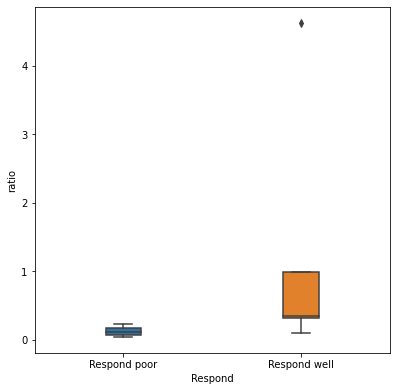

In [82]:
figure=plt.figure(figsize=(14,14))
ax1=figure.add_subplot(221)
ax1=sns.boxplot(x='Respond',y='ratio',data=GZMK_GZMB_surgey,order=['Respond poor','Respond well'],width=0.2)
mybox = ax1.artists[2]

# Change the appearance of that box
mybox.set_facecolor('red')
mybox.set_edgecolor('black')
mybox.set_linewidth(3)

plt.show()

Text(0.5, 1.0, 'GZMB/Proliferating Ratio change')

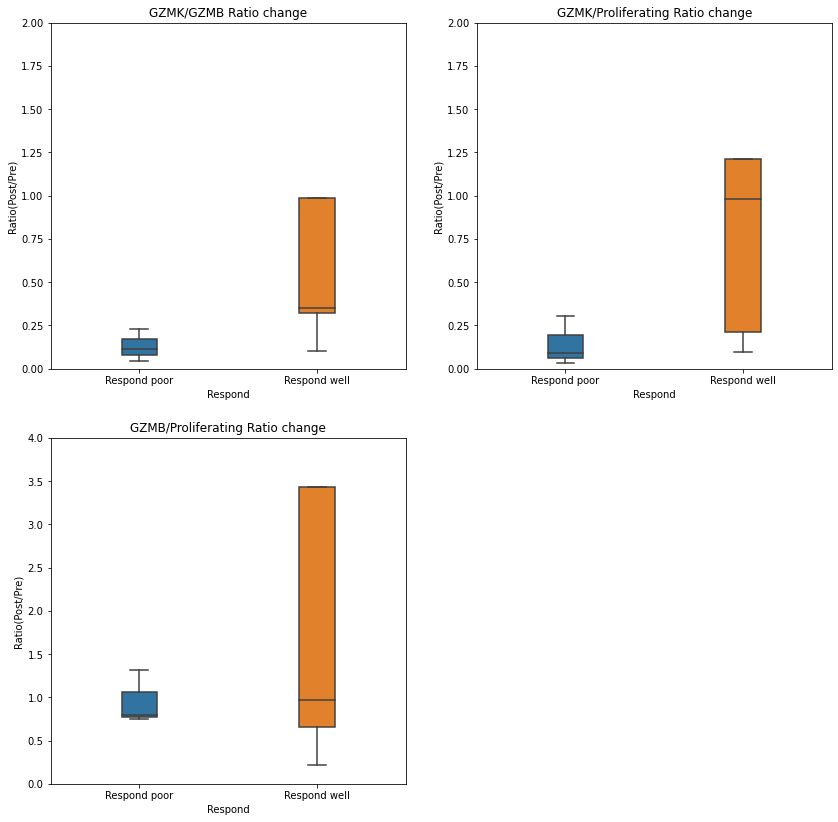

In [22]:
figure=plt.figure(figsize=(14,14))
ax1=figure.add_subplot(221)
sns.boxplot(x='Respond',y='ratio',data=GZMK_GZMB_surgey,order=['Respond poor','Respond well'],width=0.2,ax=ax1)

color=("#4DBBD5","#E64B35"),
plt.ylim([0,2])
plt.ylabel("Ratio(Post/Pre)")
plt.title("GZMK/GZMB Ratio change")
ax2=figure.add_subplot(222)
sns.boxplot(x='Respond',y='ratio',data=GZMK_pro_surgery,ax=ax2,order=['Respond poor','Respond well'],width=0.2)
plt.ylim([0,2])
plt.ylabel("Ratio(Post/Pre)")
plt.title("GZMK/Proliferating Ratio change")

ax3=figure.add_subplot(223)
sns.boxplot(x='Respond',y='ratio',data=GZMB_pro_surgery,ax=ax3,order=['Respond poor','Respond well'],width=0.2)
plt.ylim([0,4])
plt.ylabel("Ratio(Post/Pre)")
plt.title("GZMB/Proliferating Ratio change")



In [30]:
GZMK_GZMB_surgey.to_csv("/home/wull01/liver_project/source_data/Figure6NGZMK_GZMB.txt",sep="\t")
GZMK_pro_surgery.to_csv("/home/wull01/liver_project/source_data/Figure6NGZMK_pro.txt",sep="\t")
GZMB_pro_surgery.to_csv("/home/wull01/liver_project/source_data/Figure6NGZMB_pro.txt",sep="\t")

Text(0.5, 1.0, 'GZMB/Proliferating Ratio change')

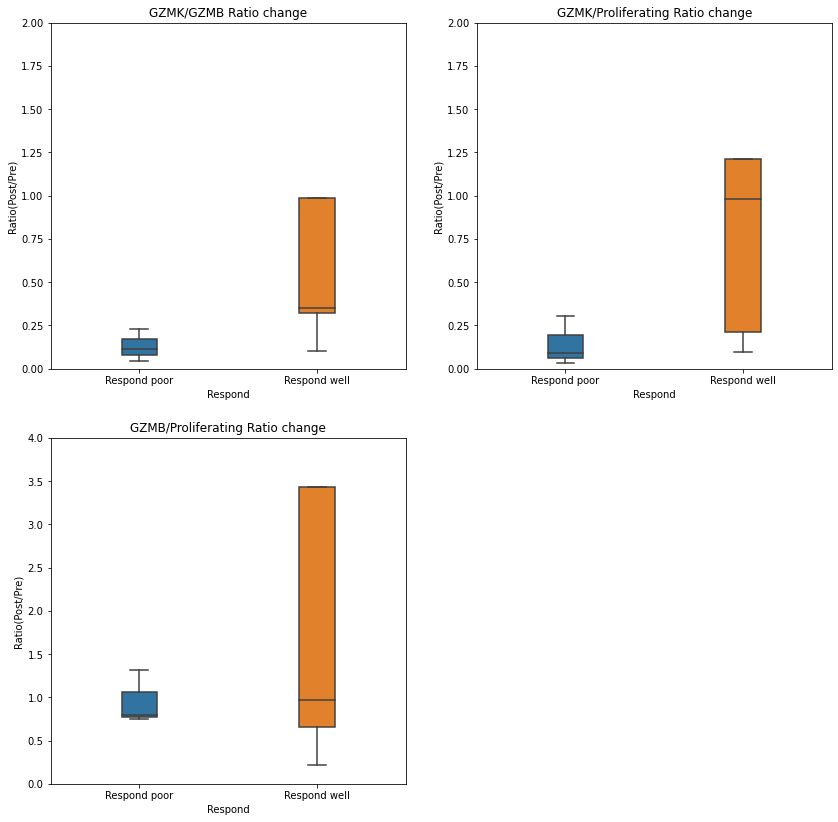

In [84]:
figure=plt.figure(figsize=(14,14))
ax1=figure.add_subplot(221)
sns.boxplot(x='Respond',y='ratio',data=GZMK_GZMB_surgey,order=['Respond poor','Respond well'],width=0.2,ax=ax1)

color=("#4DBBD5","#E64B35"),
plt.ylim([0,2])
plt.ylabel("Ratio(Post/Pre)")
plt.title("GZMK/GZMB Ratio change")
ax2=figure.add_subplot(222)
sns.boxplot(x='Respond',y='ratio',data=GZMK_pro_surgery,ax=ax2,order=['Respond poor','Respond well'],width=0.2)
plt.ylim([0,2])
plt.ylabel("Ratio(Post/Pre)")
plt.title("GZMK/Proliferating Ratio change")

ax3=figure.add_subplot(223)
sns.boxplot(x='Respond',y='ratio',data=GZMB_pro_surgery,ax=ax3,order=['Respond poor','Respond well'],width=0.2)
plt.ylim([0,4])
plt.ylabel("Ratio(Post/Pre)")
plt.title("GZMB/Proliferating Ratio change")


In [85]:
figure.savefig("Revision_plot/GZMKB_pro_ratio.svg")